In [1]:
import wave as wave
import pyroomacoustics as pa
import numpy as np
import scipy.signal as sp
import scipy as scipy

#順列計算に使用
import itertools

In [2]:
#x:入力信号( M, Nk, Lt)
#D:遅延フレーム数
#Lh:残響除去フィルタのタップ長
#return x_bar: 過去のマイク入力信号(Lh,M,Nk,Lt)
def make_x_bar(x,D,Lh):

    #フレーム数を取得
    Lt=np.shape(x)[2]

    #過去のマイク入力信号の配列を準備
    x_bar=np.zeros(shape=(Lh,)+np.shape(x),dtype=np.complex)

    for tau in range(Lh):
        x_bar[tau,...,tau+D:]=x[:,:,:-(tau+D)]

    return(x_bar)

In [3]:
#最小二乗で除去
#x:入力信号( M, Nk, Lt)
#x_bar:過去のマイク入力信号(Lh,M, Nk, Lt)
#return x_dereverb:残響除去後の信号(Nk,Lt)
def dereverberation_ls(x,x_bar):

    #マイクロホン数・周波数・フレーム数・タップ長を取得する
    M=np.shape(x)[0]
    Nk=np.shape(x)[1]
    Lt=np.shape(x)[2]
    Lh=np.shape(x_bar)[0]

    x_bar=np.reshape(x_bar,[Lh*M,Nk,Lt])
    x_bar_x_bar_h=np.einsum('ikt,jkt->kij',x_bar,np.conjugate(x_bar))
    #covariance_inverse=np.linalg.pinv(x_bar_x_bar_h)

    correlation=np.einsum('ikt,kt->ki',x_bar,np.conjugate(x[0,...]))

    filter=np.linalg.solve(x_bar_x_bar_h,correlation)

    #filter=np.einsum('kij,kj->ki',covariance_inverse,correlation)
    x_reverb=np.einsum('kj,jkt->kt',np.conjugate(filter),x_bar)

    x_dereverb=x[0,...]-x_reverb

    return(x_dereverb)

In [4]:
#WPEで残響を除去
#x:入力信号( M, Nk, Lt)
#x_bar:過去のマイク入力信号(Lh,M, Nk, Lt)
#return x_dereverb:残響除去後の信号(Nk,Lt)
def dereverberation_wpe(x,x_bar,wpe_iterations=10):

    #マイクロホン数・周波数・フレーム数・タップ長を取得する
    M=np.shape(x)[0]
    Nk=np.shape(x)[1]
    Lt=np.shape(x)[2]
    Lh=np.shape(x_bar)[0]

    #入力信号の形式を変更・変数を初期化
    x_bar=np.reshape(x_bar,[Lh*M,Nk,Lt])
    v=np.square(np.abs(x[0,...]))

    cost_buff=[]
    for t in range(wpe_iterations):
        #共分散行列を計算
        x_bar_x_bar_h=np.einsum('kt,ikt,jkt->kij',1./v,x_bar,np.conjugate(x_bar))

        #相関ベクトルを計算
        correlation=np.einsum('kt,ikt,kt->ki',1./v,x_bar,np.conjugate(x[0,...]))

        #フィルタ算出
        filter=np.linalg.solve(x_bar_x_bar_h,correlation)

        #残響除去実施
        x_reverb=np.einsum('kj,jkt->kt',np.conjugate(filter),x_bar)
        x_dereverb=x[0,...]-x_reverb

        #パラメータ更新
        v=np.square(np.abs(x_dereverb))
        v=np.maximum(v,1.e-8)

        #コスト計算
        cost=np.mean(np.log(v))
        cost_buff.append(cost)
    return(x_dereverb,cost_buff)

In [5]:
#2バイトに変換してファイルに保存
#signal: time-domain 1d array (float)
#file_name: 出力先のファイル名
#sample_rate: サンプリングレート
def write_file_from_time_signal(signal,file_name,sample_rate):
    #2バイトのデータに変換
    signal=signal.astype(np.int16)

    #waveファイルに書き込む
    wave_out = wave.open(file_name, 'w')

    #モノラル:1、ステレオ:2
    wave_out.setnchannels(1)

    #サンプルサイズ2byte
    wave_out.setsampwidth(2)

    #サンプリング周波数
    wave_out.setframerate(sample_rate)

    #データを書き込み
    wave_out.writeframes(signal)

    #ファイルを閉じる
    wave_out.close()

In [6]:
#SNRをはかる
#desired: 目的音、Lt
#out:　雑音除去後の信号 Lt
def calculate_snr(desired,out):
    wave_length=np.minimum(np.shape(desired)[0],np.shape(out)[0])

    #消し残った雑音
    desired=desired[:wave_length]
    out=out[:wave_length]
    noise=desired-out
    snr=10.*np.log10(np.sum(np.square(desired))/np.sum(np.square(noise)))

    return(snr)

In [7]:
%matplotlib inline
#%matplotlib widget

In [8]:
#乱数の種を初期化
np.random.seed(0)

In [9]:
#畳み込みに用いる音声波形
clean_wave_files=["../CMU_ARCTIC/cmu_us_aew_arctic/wav/arctic_a0001.wav"]

In [10]:
#音源数
n_sources=len(clean_wave_files)
    
#長さを調べる
n_samples=0
#ファイルを読み込む
for clean_wave_file in clean_wave_files:
    wav=wave.open(clean_wave_file)
    if n_samples<wav.getnframes():
        n_samples=wav.getnframes()
    wav.close()
    
clean_data=np.zeros([n_sources,n_samples])

#ファイルを読み込む
s=0
for clean_wave_file in clean_wave_files:
    wav=wave.open(clean_wave_file)
    data=wav.readframes(wav.getnframes())
    data=np.frombuffer(data, dtype=np.int16)
    data=data/np.iinfo(np.int16).max
    clean_data[s,:wav.getnframes()]=data
    wav.close()
    s=s+1

In [11]:
# シミュレーションのパラメータ

#シミュレーションで用いる音源数
n_sim_sources=1

#サンプリング周波数
sample_rate=16000

#フレームサイズ
N=1024

#フレームシフト
Nshift=int(N/4)


#周波数の数
Nk=int(N/2+1)

#各ビンの周波数
freqs=np.arange(0,Nk,1)*sample_rate/N

#音声と雑音との比率 [dB]
SNR=90.

In [12]:
#部屋の大きさ
room_dim = np.r_[10.0, 10.0, 10.0]

#マイクロホンアレイを置く部屋の場所
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1 

#マイクロホンアレイのマイク配置
mic_directions=np.array(
    [[np.pi/2., theta/180.*np.pi] for theta in np.arange(180,361,180)
    ]    )

distance=0.01
mic_alignments=np.zeros((3, mic_directions.shape[0]), dtype=mic_directions.dtype)
mic_alignments[0, :] = np.cos(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[1, :] = np.sin(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[2, :] = np.cos(mic_directions[:, 0])
mic_alignments *= distance

#マイクロホン数
n_channels=np.shape(mic_alignments)[1]

#マイクロホンアレイの座標
R=mic_alignments+mic_array_loc[:,None]

In [13]:
is_use_reverb=True
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17,absorption=0.4)
room_no_reverb = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

In [14]:
# 用いるマイクロホンアレイの情報を設定する
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
room_no_reverb.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

In [15]:
#音源の場所
doas=np.array(
    [[np.pi/2., np.pi]
    ]    )

#音源とマイクロホンの距離
distance=1.

source_locations=np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

In [16]:
#各音源をシミュレーションに追加する
for s in range(n_sim_sources):
    clean_data[s]/= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])
    room_no_reverb.add_source(source_locations[:, s], signal=clean_data[s])

(<Figure size 432x288 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f68181f7730>)

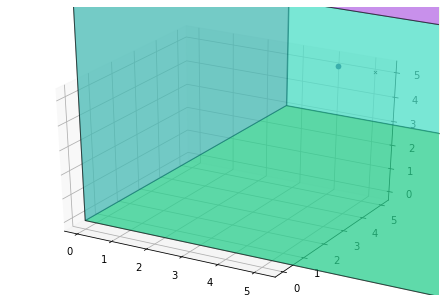

In [17]:
room.plot()

(<Figure size 432x288 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f68161a5b20>)

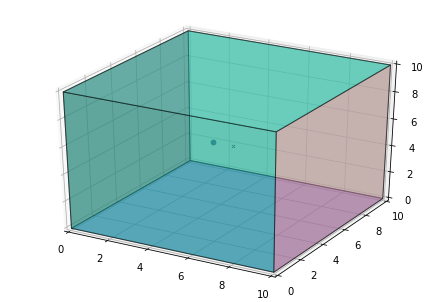

In [18]:
room_no_reverb.plot()

In [19]:
#シミュレーションを回す
room.simulate(snr=SNR)
room_no_reverb.simulate(snr=90)

#畳み込んだ波形を取得する(チャンネル、サンプル）
multi_conv_data=room.mic_array.signals
multi_conv_data_no_reverb=room_no_reverb.mic_array.signals

wave_len=np.shape(multi_conv_data_no_reverb)[1]

#畳み込んだ波形をファイルに書き込む
write_file_from_time_signal(multi_conv_data_no_reverb[0,:wave_len]*np.iinfo(np.int16).max/20.,"./dereverb_clean.wav",sample_rate)

#畳み込んだ波形をファイルに書き込む
write_file_from_time_signal(multi_conv_data[0,:wave_len]*np.iinfo(np.int16).max/20.,"./dereverb_in.wav",sample_rate)

#短時間フーリエ変換を行う
f,t,stft_data=sp.stft(multi_conv_data,fs=sample_rate,window="hann",nperseg=N,noverlap=N-Nshift)

#WPEの繰り返し回数
n_wpe_iterations=20

#残響除去のパラメータ
D=2
Lh=5

#過去のマイクロホン入力信号
x_bar=make_x_bar(stft_data,D,Lh)

#LSで残響除去
x_dereverb_ls=dereverberation_ls(stft_data,x_bar)

#WPEで残響除去
x_dereverb_wpe,cost_buff_wpe=dereverberation_wpe(stft_data,x_bar,n_wpe_iterations)

#x:入力信号( M, Nk, Lt)

t,x_dereverb_ls=sp.istft(x_dereverb_ls,fs=sample_rate,window="hann",nperseg=N,noverlap=N-Nshift)
t,x_dereverb_wpe=sp.istft(x_dereverb_wpe,fs=sample_rate,window="hann",nperseg=N,noverlap=N-Nshift)

snr_pre=calculate_snr(multi_conv_data_no_reverb[0,...],multi_conv_data[0,...])
snr_ls_post=calculate_snr(multi_conv_data_no_reverb[0,...],x_dereverb_ls)
snr_wpe_post=calculate_snr(multi_conv_data_no_reverb[0,...],x_dereverb_wpe)

write_file_from_time_signal(x_dereverb_ls[:wave_len]*np.iinfo(np.int16).max/20.,"./dereverb_ls_{}_{}.wav".format(Lh,D),sample_rate)
write_file_from_time_signal(x_dereverb_wpe[:wave_len]*np.iinfo(np.int16).max/20.,"./dereverb_wpe_{}_{}.wav".format(Lh,D),sample_rate)

print("method:    ", "LS","WPE")
print("Δsnr [dB]: {:.2f}  {:.2f}".format(snr_ls_post-snr_pre,snr_wpe_post-snr_pre))

#コストの値を表示
#for t in range(n_wpe_iterations):
#    print(t,cost_buff_wpe[t])

method:     LS WPE
Δsnr [dB]: -3.90  7.38


In [20]:
from IPython.display import display, Audio

In [21]:
display(Audio("dereverb_clean.wav", rate=sample_rate))
display(Audio("dereverb_in.wav", rate=sample_rate))
display(Audio("dereverb_ls_5_2.wav", rate=sample_rate))
display(Audio("dereverb_wpe_5_2.wav", rate=sample_rate))